# Particle in a box in 2D

Exact GS energy: $E_0 = \pi^2$

Trial WF: $\psi_T = xy(1-x)(1-y)$.

Trial energy: $E_T = 10$.

In [1]:
import sys
from pydmc import *
from plotutil import *
%matplotlib inline

In [20]:
nconf = 10
time_step = 5e-3
reference_energy = 10
blocks = 100
steps_per_block = int(1e-2/time_step * 100)
neq = 10
a0 = 1
da = 1e-5
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)
exact = np.pi**2
force_exact = np.pi**2 * 2 / a0**3

In [21]:
class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, box_width):
        self._l = box_width

    def __call__(self, x):
        y = x[1]
        x = x[0]
        return max(0, x*(self._l - x)*y*(self._l - y))

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def deform(self, da):
        return GuidingWaveFunction(self._l + da)
    
    def geometry_parameters(self):
        return self._l
    
    def geometry_gradient(self, x):
        #psisec = self.deform(1e-5)
        #return (psisec(x) - self(x))/1e-5
        return x[0]*x[1]*(2*self._l - (x[0] + x[1]))

In [22]:
np.random.seed(0)
random.seed(0)

brancher = OptimalSRBrancher()

ar = DiffuseAcceptRejectDMC(fixed_node=True)
guiding_wf = GuidingWaveFunction(a0)

lag = steps_per_block

confs = [np.random.uniform(low=0, high=1, size=2) for _ in range(nconf)]
walkers = [Walker(conf, 1.0, lag=lag) for conf in confs]

fas = [
    #DMCLogger(da, "dmc.pib.hdf5", nconf, cutoff=lambda d: cutoff_tanh(d, 0.05))
]

dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, force_accumulators=fas, velocity_cutoff=velocity_cutoff_umrigar)
dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

100%|██████████| 100/100 [00:26&lt;00:00,  3.80it/s]


In [23]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {exact:.5f}")

Energy: 9.90712 +/- 0.03543
Exact:  9.86960


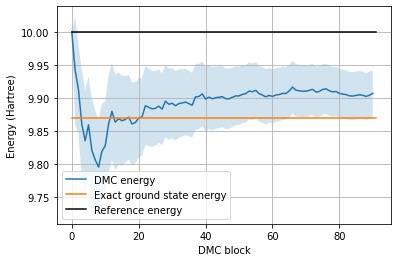

In [24]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, 
    dmc.energy_estimate - dmc.energy_error, 
    dmc.energy_estimate + dmc.energy_error, alpha=0.2)

plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], "black", label="Reference energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()

In [9]:
flhf, flhf_warp, flpulay_exact, flpulay_exact_warp, flpulay_vd, flpulay_vd_warp, flpulay_exact_nocutoff, flpulay_exact_nocutoff_warp \
    = DMCForcesInput().compute_forces("dmc.pib.hdf5")

## Exact Force

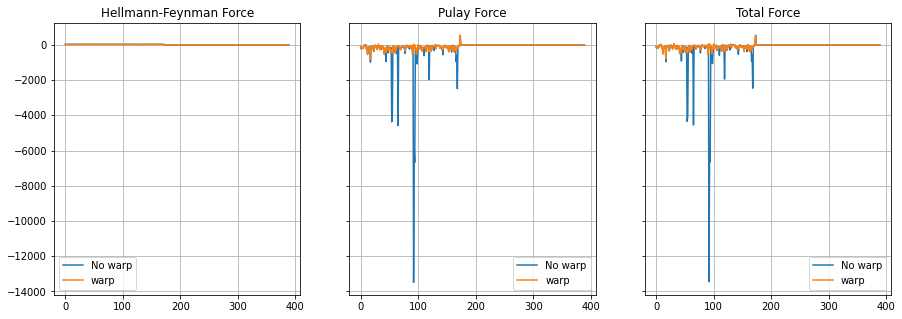

In [10]:
plot_force_data_trace(flhf, flpulay_exact_nocutoff, flhf_warp, flpulay_exact_nocutoff_warp, bin_size=1)

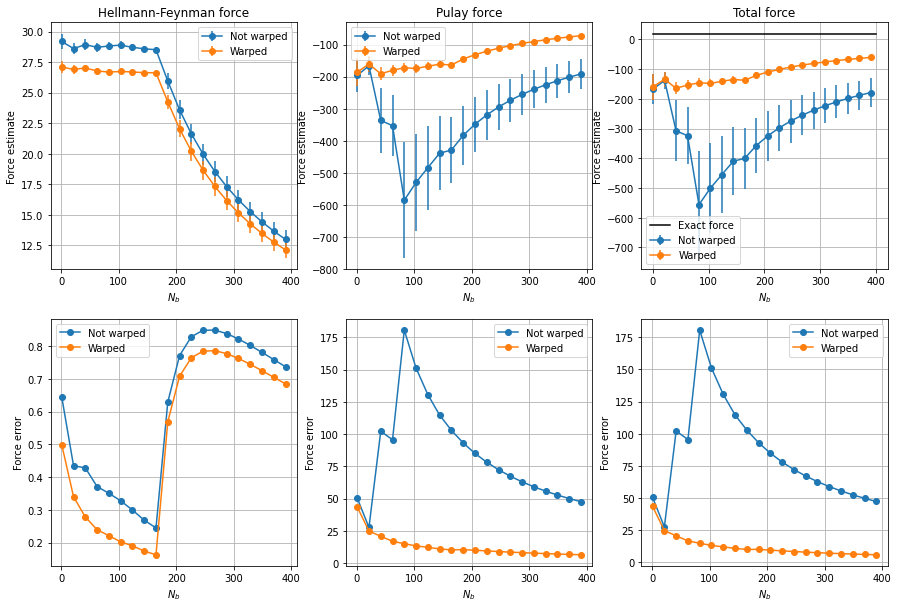

In [11]:
axes = plot_error_over_time(flhf, flpulay_exact_nocutoff, flhf_warp, flpulay_exact_nocutoff_warp, 20, 1)
for (ax, title) in zip(axes.T, ["Hellmann-Feynman force", "Pulay force", "Total force"]):
    ax[0].set_xlabel(r"$N_b$"); ax[1].set_xlabel(r"$N_b$")
    ax[0].set_ylabel("Force estimate"); ax[1].set_ylabel("Force error")
    ax[0].set_title(title)
axes[0, -1].plot([0, blocks], [force_exact]*2, "black", label="Exact force")
axes[0, -1].legend();

## VD Force

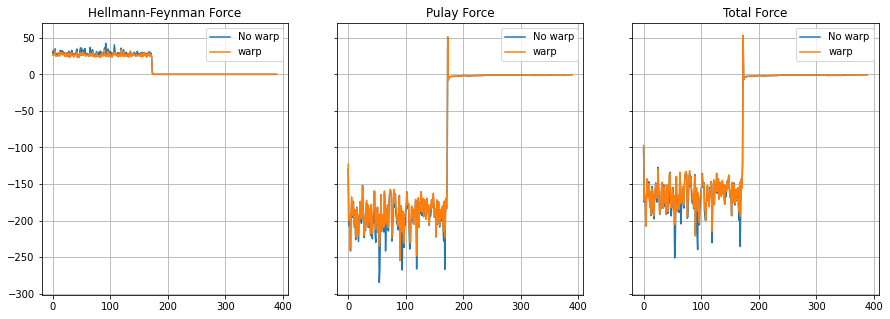

In [12]:
plot_force_data_trace(flhf, flpulay_vd, flhf_warp, flpulay_vd_warp)

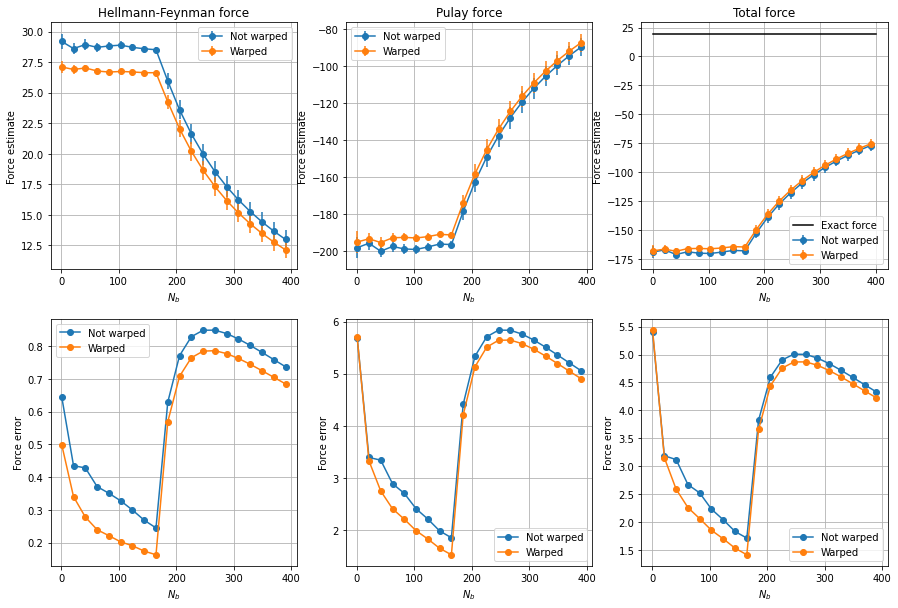

In [13]:
axes = plot_error_over_time(flhf, flpulay_vd, flhf_warp, flpulay_vd_warp, 20, 1)
for (ax, title) in zip(axes.T, ["Hellmann-Feynman force", "Pulay force", "Total force"]):
    ax[0].set_xlabel(r"$N_b$"); ax[1].set_xlabel(r"$N_b$")
    ax[0].set_ylabel("Force estimate"); ax[1].set_ylabel("Force error")
    ax[0].set_title(title)
axes[0, -1].plot([0, blocks], [force_exact]*2, "black", label="Exact force")
axes[0, -1].legend();